In [389]:
import numpy as np
import density_field_library as DFL
import config as conf
import matplotlib.pyplot as plt
from math import pi
import Pk_library as PKL
import config as conf
import my_remote_spectra as remote_spectra
import my_kszpsz_config as config
import importlib
import estim
from estim import estimator
import redshifts
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
import healpy as hp
from classy import Class

In [46]:
importlib.reload(conf)
importlib.reload(estim)
zb = redshifts.binning(conf_module = conf) 
Omega_b = conf.Omega_b
Omega_c = conf.Omega_c
w = conf.w
wa = conf.wa
Omega_K = conf.Omega_K
h = conf.h
zbins_acentral = 1/(1+zb.zbins_zcentral)
Dv_central = -remote_spectra.Dv_inter(Omega_b, Omega_c, w, wa, Omega_K, h)(zbins_acentral)

In [47]:
grid              = 64  #grid size
BoxSize           = 30000.0 #Mpc/h
seed              = 1      #value of the initial random seed
Rayleigh_sampling = 0      #whether sampling the Rayleigh distribution for modes amplitudes
threads           = 1      #number of openmp threads
verbose           = True   #whether to print some information

d = BoxSize/grid
SampleRate = 1/d
Max_k = 1/2*2*pi*SampleRate
Min_k = 2*pi/BoxSize
print(Min_k)
print(Max_k)

0.00020943951023931953
0.006702064327658226


In [48]:
kF,kN,kmax_par,kmax_per,kmax = PKL.frequencies(BoxSize, grid)
print(kF)
print(kN)

0.00020943951023931953
0.006702064327658225


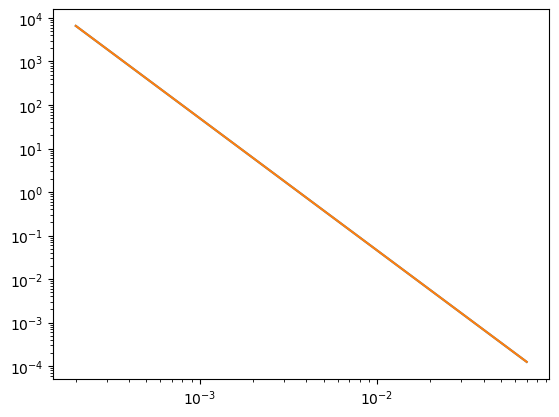

In [17]:
As= conf.As
ns = conf.ns
k_in = np.linspace(2e-4, 7e-2, 100)
# k_in = np.loadtxt('k.txt')
k_pivot = 0.05
Pk_in = 2*pi**2*As*(k_in/k_pivot)**(ns-1)*1e-9/k_in**3
P_psi = remote_spectra.Ppsi(k_in, As, ns)
if 1:
    plt.plot(k_in, Pk_in)
    plt.plot(k_in, P_psi/(2/3)**2)
    plt.xscale('log')
    plt.yscale('log')

In [18]:
Pk_in;

In [19]:
# read power spectrum; k and Pk have to be floats, not doubles
# k, Pk = np.loadtxt('my_Pk.txt', unpack=True)

k_in, Pk_in = k_in.astype(np.float32), Pk_in.astype(np.float32)
# generate a 2D Gaussian density field
# df_2D = DFL.gaussian_field_2D(grid, k, Pk, Rayleigh_sampling, seed,
                              # BoxSize, threads, verbose)
# Pk_in = Pk_in/k_in**3

# generate a 3D Gaussian density field
psi_x = DFL.gaussian_field_3D(grid, k_in, Pk_in, Rayleigh_sampling, seed,
                              BoxSize, threads, verbose)

delta(k) field generated
time taken = 0.00852 seconds



In [20]:
# test the "variance" paper setup
if 0:
    L = 313000
    Resolution = 128
    Lambda_min = 484
    k_max = 1/2*2*pi/(L/Resolution)
    print(k_max)
    print(1/2*2*pi/Lambda_min)
    print(2*pi/Lambda_min)

In [21]:
Pk = PKL.Pk(psi_x, BoxSize)
# 1D P(k)
k1D      = Pk.k1D
Pk1D     = Pk.Pk1D
Nmodes1D = Pk.Nmodes1D

# 2D P(k)
kpar     = Pk.kpar
kper     = Pk.kper
Pk2D     = Pk.Pk2D
Nmodes2D = Pk.Nmodes2D

# 3D P(k)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0] #monopole
Pk2     = Pk.Pk[:,1] #quadrupole
Pk4     = Pk.Pk[:,2] #hexadecapole
Pkphase = Pk.Pkphase #power spectrum of the phases
Nmodes  = Pk.Nmodes3D
np.savetxt('k.txt', k)


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds


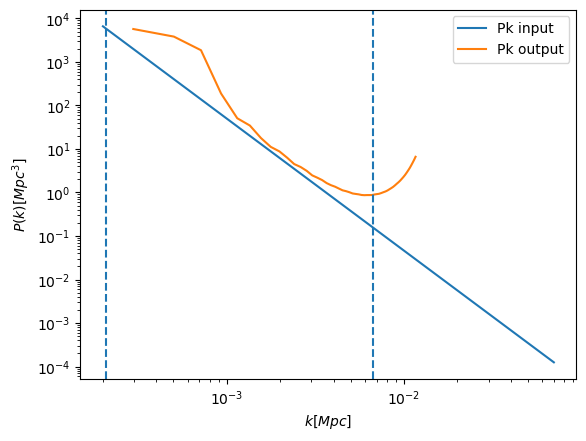

In [22]:
plt.plot(k_in, Pk_in, label='Pk input')
# plt.plot(k[:20], Pk0[:20], label='Pk output')
plt.plot(k, Pk0, label='Pk output')

# # shot_noise
# shot_noise = BoxSize**3/grid**3*np.ones_like(k)
# plt.plot(k, shot_noise)

plt.xscale('log')
plt.yscale('log')
plt.axvline(x=Max_k, linestyle = '--')
plt.axvline(x=Min_k, linestyle = '--')
plt.xlabel(r'$k[Mpc]$')
plt.ylabel(r'$P(k)[Mpc^3]$')
plt.legend()

In [23]:
# plt.plot(k_in, Pk_in, label='Pk input')
# # plt.plot(k[:20], Pk0[:20], label='Pk output')
# plt.plot(k, Pk0, label='Pk output')
# # plt.plot(k, BoxSize**3/grid**3*k**3/1e8)

# plt.xscale('log')
# plt.yscale('log')
# # plt.axvline(x=Max_k, linestyle = '--')
# # plt.axvline(x=Min_k, linestyle = '--')
# plt.xlabel('k[Mpc]')
# plt.legend()

In [24]:
# 3-d real space axes
d = BoxSize/grid
x = np.arange(-BoxSize/2, BoxSize/2, d)
y = np.arange(-BoxSize/2, BoxSize/2, d)
z = np.arange(-BoxSize/2, BoxSize/2, d)
# 3-d meshgrid coordinate
# xx, yy = np.meshgrid(x, y)
xx, yy, zz = np.meshgrid(x, y, z)
rr = np.sqrt(xx**2 + yy**2 + zz**2)
print(xx.shape)

(64, 64, 64)


In [84]:
if 1:
    k_x = np.fft.fftfreq(grid, d)
    k_y = np.fft.fftfreq(grid, d)
    k_z = np.fft.fftfreq(grid, d)
    kk_x, kk_y, kk_z = np.meshgrid(k_x, k_y, k_z)
    kk_x_s, kk_y_s, kk_z_s = np.fft.fftshift(kk_x), np.fft.fftshift(kk_y), np.fft.fftshift(kk_z)
    
    kk  = np.sqrt(kk_x**2 + kk_y**2 + kk_z**2)
    kk_s  = np.sqrt(kk_x_s**2 + kk_y_s**2 + kk_z_s**2)
    print(kk.shape)

(64, 64, 64)


In [86]:
2*pi*3.33333333e-05

0.00020943951002988002

In [87]:
# check the 3d k abs values, looks good
print(kk.min())
print(kk.max())
print(2*pi*kk.max())
print(k.max())
print(k.min())

0.0
0.0018475208614068025
0.011608315931098994
0.011608315931098992
0.00029665470748989846


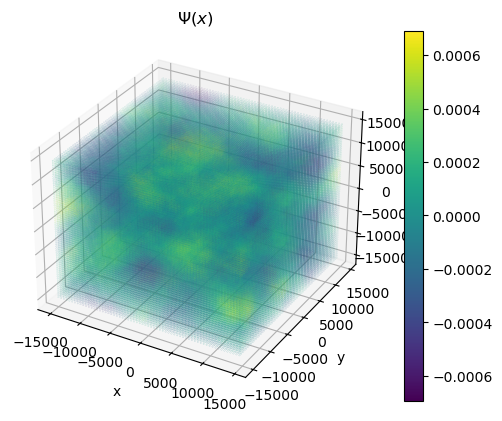

In [26]:
if 1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.colorbar(ax.scatter(xx,yy,zz,c=psi_x, s=0.01))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$\Psi (x)$');

In [27]:
a = 0.8
D_psi = remote_spectra.Dpsi_inter(Omega_b, Omega_c, w, wa, Omega_K, h)(a)
psi_x_a = D_psi*psi_x

In [28]:
Pk_a = PKL.Pk(psi_x_a, BoxSize)
# 3D P(k)
k_a  = Pk_a.k3D
Pk0_a = Pk_a.Pk[:,0]


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds


In [29]:
# plt.plot(k_in[2:400], Pk_in[2:400], label='Pk input')
if 0:
    plt.plot(k, Pk0, label='Pk output')
    plt.plot(k_a, Pk0_a, label='Pk_a output')
    plt.plot(k_in, Pk_in, label='Pk input')
    plt.axvline(x=Max_k, linestyle = '--')
    plt.axvline(x=Min_k, linestyle = '--')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    # have to check carefully https://github.com/franciscovillaescusa/Pylians3/blob/master/density_field/Gaussian_density_field.py

In [291]:
# Now let's add the inhomogeneous potential psi_i_x where i for inhomogeneous
import param
importlib.reload(param)
A = param.A
B = param.B
x_c = param.x_c
r_H = param.r_H
print(A)
print(B)
print(x_c)
print(r_H)

0.001
0.0
0
4411.764705882353


In [292]:
x_xc = np.concatenate((np.zeros(int((BoxSize/2+x_c)/d)), np.arange(0, BoxSize/2-x_c, d)))
xx_xc, _, _ = np.meshgrid(x_xc, y, z)
psi_i_x = A*(xx_xc/r_H) + B*(xx_xc/r_H)**2
g_psi_i = np.gradient(psi_i_x)

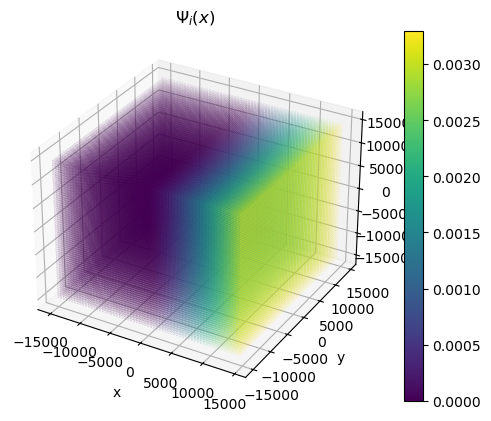

In [293]:
if 1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.colorbar(ax.scatter(xx,yy,zz,c=psi_i_x, s=0.01))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$\Psi_{i} (x)$');

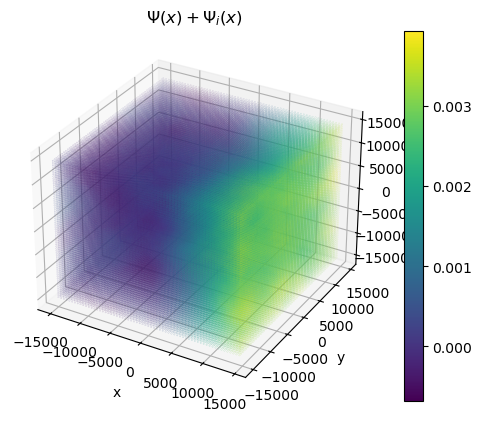

In [294]:
if 1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.colorbar(ax.scatter(xx,yy,zz,c=psi_x+psi_i_x, s=0.01))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$\Psi (x) + \Psi_{i} (x)$');

In [295]:
Pk_test = PKL.Pk(psi_x+np.float32(psi_i_x), BoxSize)
# 3D P(k)
k_test       = Pk_test.k3D
Pk0_test     = Pk_test.Pk[:,0] #monopole
# Pk2     = Pk.Pk[:,1] #quadrupole
# Pk4     = Pk.Pk[:,2] #hexadecapole
# Pkphase = Pk.Pkphase #power spectrum of the phases
# Nmodes  = Pk.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds


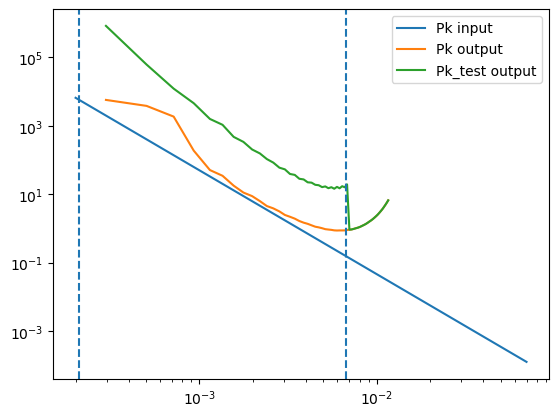

In [296]:
plt.plot(k_in, Pk_in, label='Pk input')
# plt.plot(k[:20], Pk0[:20], label='Pk output')
plt.plot(k, Pk0, label='Pk output')
plt.plot(k, Pk0_test, label='Pk_test output')

plt.xscale('log')
plt.yscale('log')
plt.axvline(x=Max_k, linestyle = '--')
plt.axvline(x=Min_k, linestyle = '--')
plt.legend()

Text(0.5, 0, '$k[Mpc]$')

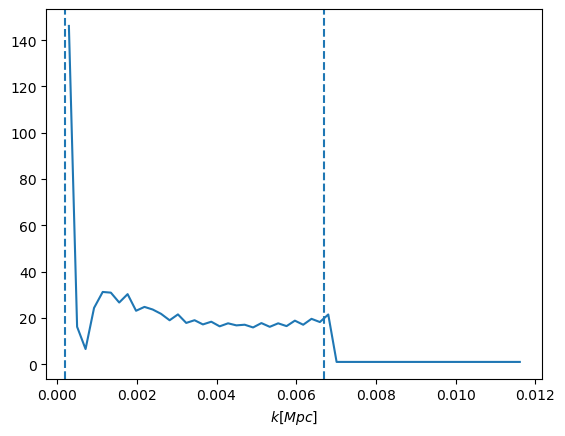

In [297]:
plt.plot(k, Pk0_test/Pk0)
plt.axvline(x=Max_k, linestyle = '--')
plt.axvline(x=Min_k, linestyle = '--')
plt.xlabel(r'$k[Mpc]$')

In [298]:
c = 3e5
H = 70
H/c

0.00023333333333333333

In [299]:
# now we consider the evolution of effective velocity field, i.e., work on the Fourier kernel of SW, ISW and Doppler effects
# these have been tested in V_eff_calculation.ipynb

In [300]:
# I would like to figure out how to do multiplication in Fourier space at first
# construct the k-spac

In [301]:
importlib.reload(config)
importlib.reload(remote_spectra)
w0 = -0.7
# wa = 0
ag = remote_spectra.ag
# Ea = spectra.E(ag, config.Omega_b, config.Omega_c, config.w, config.wa, config.Omega_K, config.h)
# Ea_w0wa = spectra.E(ag, config.Omega_b, config.Omega_c, w0, wa, config.Omega_K, config.h)
Dpsi = remote_spectra.Dpsi_inter_config(config)(ag)
Dv = remote_spectra.Dv_inter_config(config)(ag)

In [302]:
# ks = 0.0001
ks = config.kaux
# ks = np.linspace(0.00001, 0.01, 50)
ze = 1
# zes = np.linspace(1,5,10)
G_SW_ksz = remote_spectra.G_SW_ksz(ks, ze, config.Omega_b, config.Omega_c, config.w, config.wa, config.Omega_K, config.h)

G_Dopp_ksz = remote_spectra.G_Dopp_ksz(ks, ze, config.Omega_b, config.Omega_c, config.w, config.wa, config.Omega_K, config.h)

G_ISW_ksz = remote_spectra.G_ISW_ksz(ks, ze, config.Omega_b, config.Omega_c, config.w, config.wa, config.Omega_K, config.h)

G_Veff = G_SW_ksz + G_Dopp_ksz + G_ISW_ksz

Text(0.5, 0, '$k[Mpc]^{-1}$')

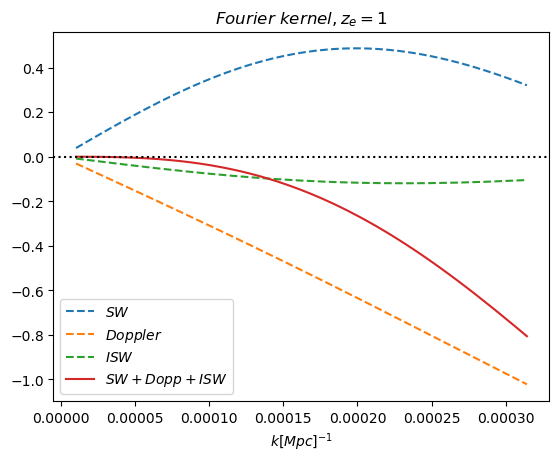

In [304]:
num_k_max = 150
plt.plot(ks[:num_k_max], G_SW_ksz[:num_k_max], '--', label=r'$SW$')
# plt.plot(ks, G_SW_ksz_w0wa, '--', label=r'$SW\ w_{0}w_{a}$')

plt.plot(ks[:num_k_max], G_Dopp_ksz[:num_k_max],'--', label=r'$Doppler$')
# plt.plot(ks, G_Dopp_ksz_w0wa, label=r'$Doppler\ w_{0}w_{a}$')

plt.plot(ks[:num_k_max], G_ISW_ksz[:num_k_max], '--', label=r'$ISW$')
# plt.plot(ks, G_ISW_ksz_w0wa, '-.', label=r'$ISW\ w_{0}w_{a}$')

plt.plot(ks[:num_k_max], G_SW_ksz[:num_k_max]+G_Dopp_ksz[:num_k_max]+G_ISW_ksz[:num_k_max], '-', label=r'$SW+Dopp+ISW$')

plt.axhline(y=0, linestyle = ':', c='k')
plt.legend()
plt.xlabel(r'$k$')
plt.title(r'$Fourier\ kernel, z_{e}=%s$' %ze)
plt.xlabel(r'$k[Mpc]^{-1}$')

In [382]:
G_psi_x = np.gradient(psi_x)
G_psi_i_x = np.gradient(psi_i_x)

G_psi_k = np.fft.fftn(G_psi_x)
G_psi_i_k = np.fft.fftn(G_psi_i_x)

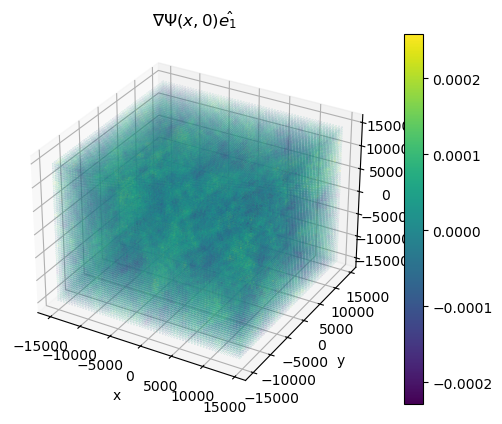

In [383]:
if 1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.colorbar(ax.scatter(xx,yy,zz,c=G_psi_x[1], s=0.01))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$\nabla \Psi (x,0)\hat{e_1}$');

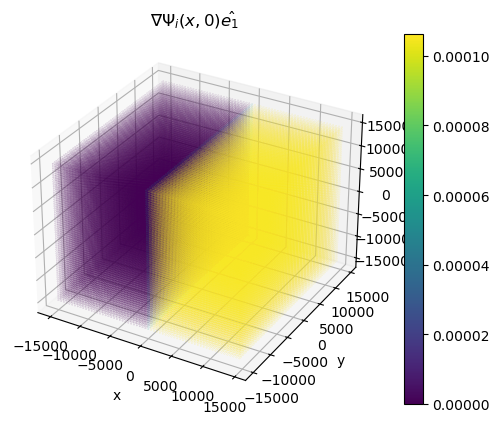

In [384]:
if 1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    fig.colorbar(ax.scatter(xx,yy,zz,c=G_psi_i_x[1], s=0.01))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$\nabla \Psi_i (x,0)\hat{e_1}$');

In [411]:
# xyz direction V_eff FFT component, labeled by k1, k2, k3
G_SW_ksz_itp = interp1d(ks, G_SW_ksz)
G_ISW_ksz_itp = interp1d(ks, G_ISW_ksz)
G_Dopp_ksz_itp = interp1d(ks, G_Dopp_ksz)
G_ksz_itp = interp1d(ks, G_SW_ksz + G_ISW_ksz + G_Dopp_ksz)

G_itp = G_SW_ksz_itp
# G_itp = G_ksz_itp

# G_field_k = G_psi_k
G_field_k = G_psi_k+G_psi_i_k
# G_field_k = G_psi_i_k

kk[0,0,0] = 1
V_eff_k1 = np.concatenate(([0], G_itp(kk.flatten()[1:]))).reshape(kk.shape)*G_field_k[1]/kk
V_eff_k2 = np.concatenate(([0], G_itp(kk.flatten()[1:]))).reshape(kk.shape)*G_field_k[2]/kk
V_eff_k3 = np.concatenate(([0], G_itp(kk.flatten()[1:]))).reshape(kk.shape)*G_field_k[0]/kk

# xyz direction V_eff component, labeled by x1, x2, x3
V_eff_x1 = np.fft.ifftn(V_eff_k1)
V_eff_x2 = np.fft.ifftn(V_eff_k2)
V_eff_x3 = np.fft.ifftn(V_eff_k3)

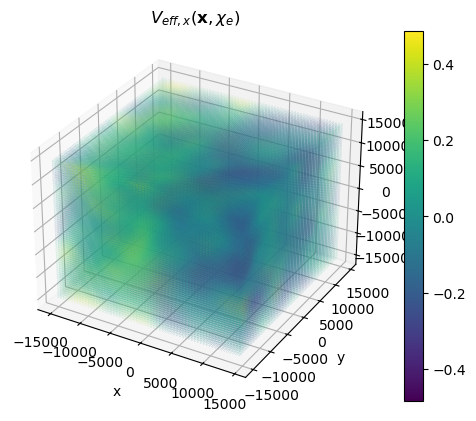

In [427]:
V_eff_component = V_eff_x1.real
if 1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    fig.colorbar(ax.scatter(xx,yy,zz,c=V_eff_component, s=0.01))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$V_{eff,x}(\mathbf{x}, \chi_e)$');

In [428]:
common_settings = {# LambdaCDM parameters
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.12038,
                   'A_s':2.100549e-09,
                   'n_s': 0.9660499,
                   'tau_reio':0.05430842,
                   'gauge':'newtonian'
                   }
M = Class()
M.set(common_settings)
M.compute()

In [429]:
# compare the transfer functions generated by Class with Eq.(A.6), beforing doing 
# this, I need to get some background and thermodynamic quantities
background = M.get_background()
thermodynamics = M.get_thermodynamics()

In [430]:
background_tau = background['conf. time [Mpc]'] # read conformal times in background table
background_z = background['z'] # read redshift
background_a = 1/(1+background_z)

background_rho_m_over_r =\
    (background['(.)rho_b']+background['(.)rho_cdm'])\
    /(background['(.)rho_g']+background['(.)rho_ur']) # read rho_r / rho_m (to find time of equality)
background_tau_at_mr = interp1d(background_rho_m_over_r, background_z) # define interpolation function
z_eq = background_tau_at_mr(1.) # z for radiation-matter equility
a_eq = 1/(1+z_eq) # a for radiation-matter equility

# Omg_g and Omg_m interpolation functions
background_Omg_m_at_a_itp = interp1d(background_a, ((background['(.)rho_b']+background['(.)rho_cdm'])/\
                           background['(.)rho_tot']))
background_Omg_lambda_at_a_itp = interp1d(background_a, background['(.)rho_lambda']/background['(.)rho_tot'])
background_H_at_a_itp = interp1d(background_a, background['H [1/Mpc]'])
background_tau_at_a_itp = interp1d(background_a, background['conf. time [Mpc]'])
background_a_at_tau_itp = interp1d(background['conf. time [Mpc]'], background_a)

In [431]:
# try to plot the sphere on heapix plot
# https://healpy.readthedocs.io/en/latest/tutorial.html
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

a_e = 1/(1+ze)
# firstly obtain all the points at r_e = tau(a=1)-tau(a=a_e)
r_e = background_tau_at_a_itp(1) - background_tau_at_a_itp(a_e)
print(r_e)

theta, phi = np.degrees(hp.pix2ang(nside=NSIDE, ipix=np.arange(NPIX)))
theta = theta * pi / 180.0
phi = phi * pi / 180.0

x_test_s = r_e*np.sin(theta)*np.cos(phi)
y_test_s = r_e*np.sin(theta)*np.sin(phi)
z_test_s = r_e*np.cos(theta)

if 0:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(x_test_s,y_test_s,z_test_s, s=0.2)
    # ax.set_xlim([-r_o, r_o])
    # ax.set_ylim([-r_o, r_o])
    # ax.set_zlim([-r_o, r_o])
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    # ax.view_init(90, -90) 

# looks pretty good!

3389.2627692740098


In [432]:
V_eff_x1_itp = RegularGridInterpolator((x, y, z), V_eff_x1.real)
V_eff_x2_itp = RegularGridInterpolator((x, y, z), V_eff_x2.real)
V_eff_x3_itp = RegularGridInterpolator((x, y, z), V_eff_x3.real)

In [433]:
V_eff_x1_chi = V_eff_x1_itp((z_test_s, x_test_s, y_test_s))
V_eff_x2_chi = V_eff_x2_itp((z_test_s, x_test_s, y_test_s))
V_eff_x3_chi = V_eff_x3_itp((z_test_s, x_test_s, y_test_s))
V_eff_radial = V_eff_x1_chi*np.sin(theta)*np.cos(phi) + V_eff_x2_chi*np.sin(theta)*np.sin(phi) + V_eff_x3_chi*np.cos(theta)

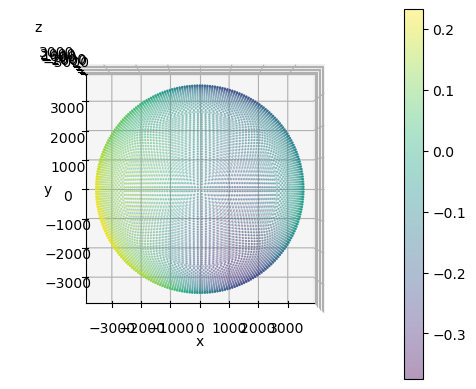

In [434]:
# check https://stackoverflow.com/questions/11140163/plotting-a-3d-cube-a-sphere-and-a-vector
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.colorbar(ax.scatter(x_test_s, y_test_s, z_test_s, c=V_eff_x1_chi, alpha=0.4, label=r'$r_{edec}$', s=0.2))
# ax.scatter(x_e,y_e,z_e, color='r', s=10)
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')

# ax.plot_surface(xx_c, yy_c, zz_c, alpha=0.2)
# ax.set_xlim([-r_o, r_o])
# ax.set_ylim([-r_o, r_o])
# ax.set_zlim([-r_o, r_o])
# ax.legend()
# check xy direction view
ax.view_init(90, -90) 

Text(0.5, 0, 'z')

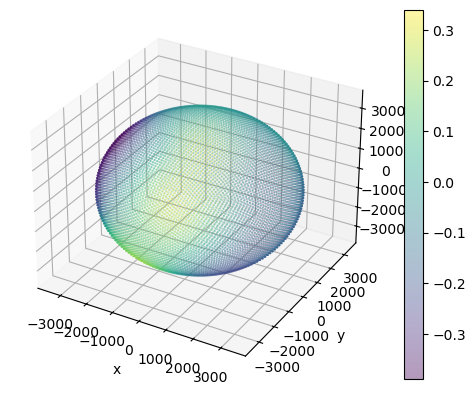

In [435]:
# check https://stackoverflow.com/questions/11140163/plotting-a-3d-cube-a-sphere-and-a-vector
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.colorbar(ax.scatter(x_test_s, y_test_s, z_test_s, c=V_eff_radial, alpha=0.4, label=r'$r_{edec}$', s=0.2))
# ax.scatter(x_e,y_e,z_e, color='r', s=10)
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')

# ax.plot_surface(xx_c, yy_c, zz_c, alpha=0.2)
# ax.set_xlim([-r_o, r_o])
# ax.set_ylim([-r_o, r_o])
# ax.set_zlim([-r_o, r_o])
# ax.legend()
# check xy direction view
# ax.view_init(90, -90) 

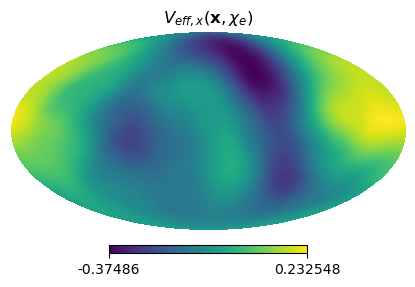

In [436]:
if 1:
    plt.figure(figsize=(4,3))
    hp.mollview(V_eff_x1_chi, xsize=800, sub=111, title=r'$V_{eff, x}(\mathbf{x}, \chi_e)$')

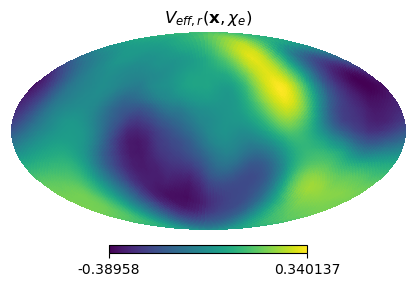

In [437]:
if 1:
    plt.figure(figsize=(4,3))
    hp.mollview(V_eff_radial, xsize=800, sub=111, title=r'$V_{eff, r}(\mathbf{x}, \chi_e)$')

In [ ]:
# quadrupole?